# $$ Deep - QLearning$$

## Imports

In [11]:
# imports from libs
import sys
import numpy as np
import math
import random
import gym
import gym_maze
import os

from collections import deque
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense

# imports from project
from utils.plotting import plot_line_graphs_overlayed
from utils.file_management import create_folder_structure
from utils.file_management import save_nparray_to_folder

ImportError: DLL load failed: Não foi possível encontrar o módulo especificado.

## Setting Saving Directory

In [7]:
cwd = os.getcwd()
SAVING_RESULTS_FODLER = os.path.join(cwd,"results","Q_LEANING_Deep")
SAVING_RESULTS_FODLER

'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\Q_LEANING_Deep'

## Constants

In [8]:
# Initialize the "maze" environment
env = gym.make("maze-random-10x10-plus-v0")

'''
Defining the environment related constants
'''
# Number of discrete states (bucket) per state dimension
MAZE_SIZE = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
NUM_BUCKETS = MAZE_SIZE  # one bucket per grid

# Number of discrete actions
NUM_ACTIONS = env.action_space.n  # ["N", "S", "E", "W"]
# Bounds for each discrete state
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))

'''
Learning related constants
'''
MIN_EXPLORE_RATE = 0.001
DECAY_FACTOR = np.prod(MAZE_SIZE, dtype=float) / 10.0

'''
Defining the simulation related constants
'''
NUM_EPISODES = 1000
MAX_T = np.prod(MAZE_SIZE, dtype=int) * 100
STREAK_TO_END = 100
SOLVED_T = np.prod(MAZE_SIZE, dtype=int)
RENDER_MAZE = False
ENABLE_RECORDING = False

'''
Q-Learning Related Constants
'''
DISCOUNT_FACTOR = 0.99
LEARNING_RATE = 0.01

'''
CREATING RESULTS SAVING FOLDERS
'''
SAVING_RESULTS_IMAGE_FODLER = os.path.join(SAVING_RESULTS_FODLER,"images")
SAVING_RESULTS_VIDEO_FODLER = os.path.join(SAVING_RESULTS_FODLER,"videos")
SAVING_RESULTS_ARRAY_FODLER = os.path.join(SAVING_RESULTS_FODLER,"arrays")
SAVING_RESULTS_WEIGHTS_FODLER = os.path.join(SAVING_RESULTS_FODLER,"weights")
create_folder_structure(SAVING_RESULTS_IMAGE_FODLER)
create_folder_structure(SAVING_RESULTS_VIDEO_FODLER)
create_folder_structure(SAVING_RESULTS_ARRAY_FODLER)
create_folder_structure(SAVING_RESULTS_WEIGHTS_FODLER)

'''
ENABLE RECORDING
'''
if ENABLE_RECORDING:
    env = gym.wrappers.Monitor(env,SAVING_RESULTS_VIDEO_FODLER, force=True)

NameError: name 'create_folder_structure' is not defined

## Network

In [4]:
model = Sequential()
model.add(Dense(32, activation='relu', name='fc1', input_shape=env.observation_space.shape))
model.add(Dense(32, activation='relu', name='fc2'))
model.add(Dense(env.action_space.n, name='fc3'))
model.summary()

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

NameError: name 'Sequential' is not defined

## Memory

In [ ]:
# class Memory():
#     def __init__(self, max_size):
#         self.buffer = deque(maxlen = max_size)
    
#     def add(self, experience):
#         self.buffer.append(experience)
    
#     def sample(self, batch_size):
#         buffer_size = len(self.buffer)
#         index = np.random.choice(np.arange(buffer_size),
#                                 size = batch_size,
#                                 replace = False)
        
#         return [self.buffer[i] for i in index]



In [ ]:
BATCH_SIZE = 64
buffer = deque(maxlen=2000) # A circular buffer with max of 2000 samples

while len(buffer) < BATCH_SIZE: # Fill buffer with one batch, so we can start learning
    state = env.reset()
    done = False
    
    while not done:
        action = env.action_space.sample()
        new_state, reward, done, info = env.step(action)
        transition = (state, action, reward, new_state, done)
        buffer.append(transition) # Store trasition in the buffer

## Algorithm Training

In [6]:
def training(model,
             
             discount_factor:float= 0.99,
             learning_rate:float= 0.01):
    """Simulate Q-Learning Algorythim .

    Args:
        discount_factor (float): gamma.

    Returns:
        np.array(reward_episode_list): Numpy array with the episodes rewards
        np.array(explore_rate_episode_list): Numpy array with the episodes explore rates
        np.array(num_streaks_episode_list): Numpy array with the episodes number of mazze completions
        np.array(length_episode_list): Numpy array with the episodes lengths
    """

    #creating episodes results lists
    
    reward_episode_list = []
    explore_rate_episode_list = []
    num_streaks_episode_list = []
    length_episode_list = []

    # Instantiating the learning related parameters
    explore_rate = get_explore_rate(0)

    # Render tha maze
    env.render()

    # Initialize q_table
    q_table = np.zeros(NUM_BUCKETS + (NUM_ACTIONS,), dtype=float)
    
    #Initializain num streaks
    num_streaks= 0

    for episode in range(NUM_EPISODES):

        # Reset the environment
        obv = env.reset()

        # the initial state
        state = state_to_bucket(obv)
        total_reward = 0


        for t in range(MAX_T):

            # Select an action
            action = epsilon_greedy_police(state, explore_rate,q_table)

            # execute the action
            obv, reward, done, _ = env.step(action)

            # Observe the result
            next_state = state_to_bucket(obv)
            total_reward += reward
            
            # TD Update
            q_values_next = model.predict(next_state)

            #TD Target
            td_target = reward + discount_factor * np.max(q_values_next)

            # Update the function approximator using our target
            estimator.update(state, action, td_target)

            # Setting up for the next iteration
            state = next_state


            # Render tha maze
            if RENDER_MAZE:
                env.render()

            if env.is_game_over():
                sys.exit()

            if done:
                print(f"Episode {episode} finished after {t} time steps with total reward = {total_reward} (streak {num_streaks}).")

                if t <= SOLVED_T:
                    num_streaks += 1
                else:
                    num_streaks = 0
                break

            elif t >= MAX_T - 1:
                print(f"Episode {episode} timed out at {t} with total reward = {total_reward}.")

        # Appending Episode values to the list
        reward_episode_list.append(total_reward)
        explore_rate_episode_list.append(explore_rate)
        num_streaks_episode_list.append(num_streaks)
        length_episode_list.append(t)

        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > STREAK_TO_END:
            break

        # Update parameters
        explore_rate = get_explore_rate(episode)


    print("FINAL ACTION TABLE \n")
    acts = ["N", "S", "E", "W"]
    for i in range(q_table.shape[2]):
        print(f"Action {acts[i]} table \n {q_table[:,:,i]}\n")

    return (np.array(reward_episode_list),
            np.array(explore_rate_episode_list),
            np.array(num_streaks_episode_list),
            np.array(length_episode_list))


## Epsilon Greed Exploration

In [7]:
def epsilon_greedy_police(state, explore_rate,q_table):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = int(np.argmax(q_table[state]))
    return action

## Updating EXPLORE_RATE and LEARNING_RATE

In [8]:
def get_explore_rate(t):
    return max(MIN_EXPLORE_RATE, min(0.8, 1.0 - math.log10((t+1)/DECAY_FACTOR)))

## Function that returns the actual state

In [9]:
def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)

## Running

In [10]:
estimator = Estimator()
reward_episode_array,explore_rate_episode_array,num_streaks_episode_array,length_episode_array = \
        simulate(estimator = estimator,
                discount_factor = DISCOUNT_FACTOR,
                learning_rate = LEARNING_RATE)

if ENABLE_RECORDING:
    env.monitor.close()

tal reward = -9.999999999999897.
Episode 735 timed out at 9999 with total reward = -9.999999999999897.
Episode 736 timed out at 9999 with total reward = -9.999999999999897.
Episode 737 timed out at 9999 with total reward = -9.999999999999897.
Episode 738 timed out at 9999 with total reward = -9.999999999999897.
Episode 739 timed out at 9999 with total reward = -9.999999999999897.
Episode 740 timed out at 9999 with total reward = -9.999999999999897.
Episode 741 timed out at 9999 with total reward = -9.999999999999897.
Episode 742 timed out at 9999 with total reward = -9.999999999999897.
Episode 743 timed out at 9999 with total reward = -9.999999999999897.
Episode 744 timed out at 9999 with total reward = -9.999999999999897.
Episode 745 timed out at 9999 with total reward = -9.999999999999897.
Episode 746 timed out at 9999 with total reward = -9.999999999999897.
Episode 747 timed out at 9999 with total reward = -9.999999999999897.
Episode 748 timed out at 9999 with total reward = -9.9999

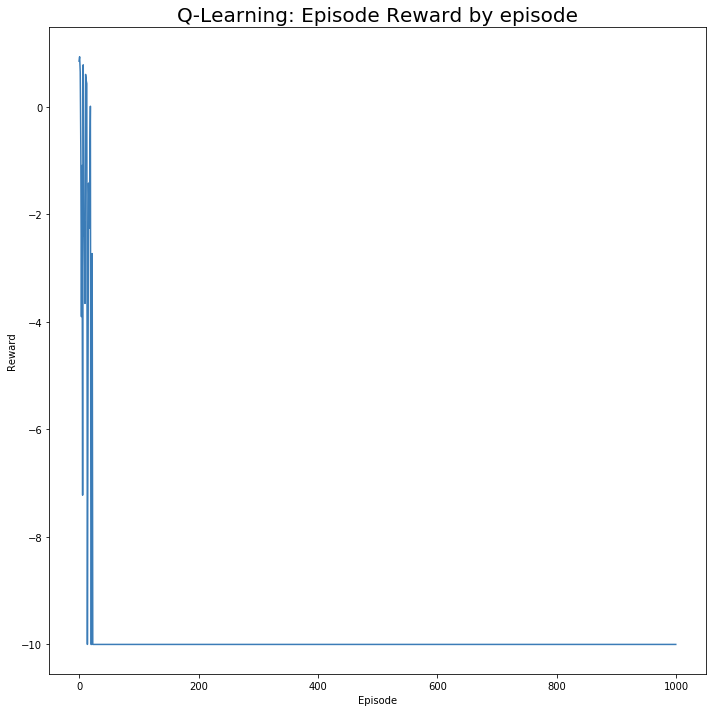

<Figure size 432x288 with 0 Axes>

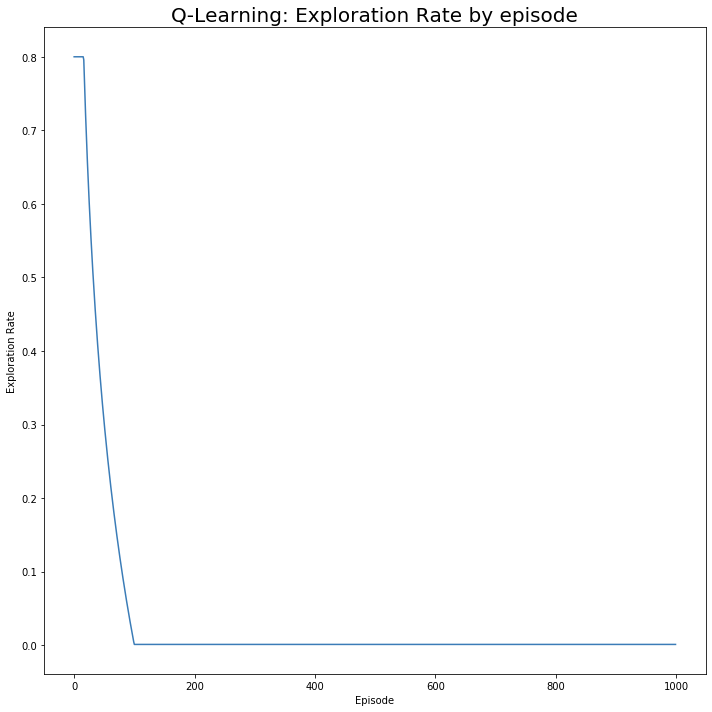

<Figure size 432x288 with 0 Axes>

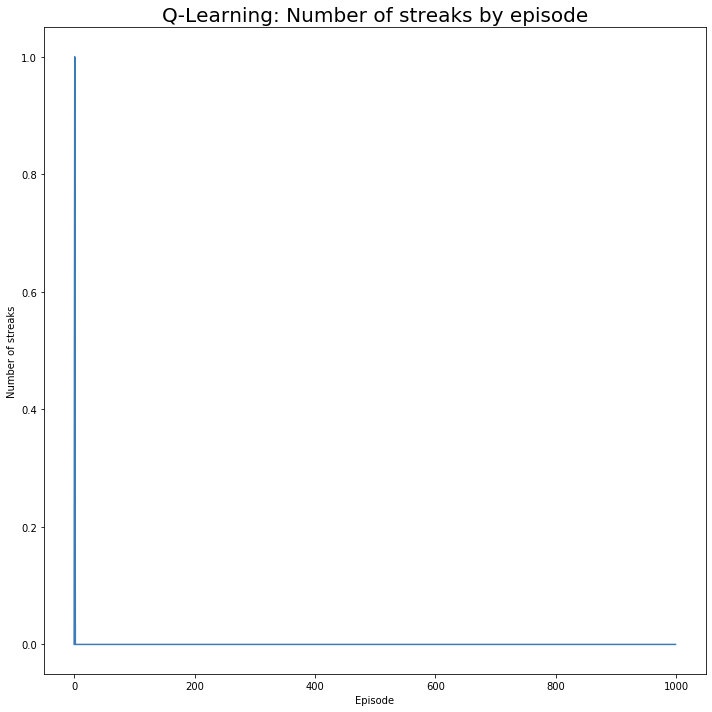

<Figure size 432x288 with 0 Axes>

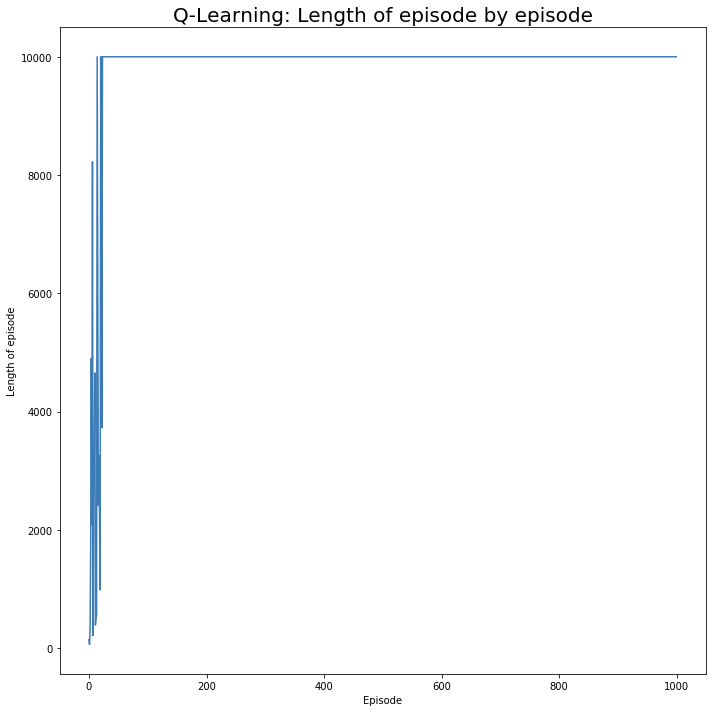

<Figure size 432x288 with 0 Axes>

In [11]:
graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"reward_episode")
plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [reward_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Reward",
                            legends = ["None_Marker"],
                            title = "Q-Learning: Episode Reward by episode" ,
                            graph_saving_path = graph_saving_path)


graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"explore_rate_episode_array")
plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [explore_rate_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Exploration Rate",
                            legends = ["None_Marker"],
                            title = "Q-Learning: Exploration Rate by episode" ,
                            graph_saving_path = graph_saving_path)


graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"num_streaks_episode_array")
plot_line_graphs_overlayed(x_list =[range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [num_streaks_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Number of streaks",
                            legends = ["None_Marker"],
                            title = "Q-Learning: Number of streaks by episode" ,
                            graph_saving_path = graph_saving_path)


graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"length_episode_array")
plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [length_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Length of episode",
                            legends = ["None_Marker"],
                            title = "Q-Learning: Length of episode by episode" ,
                            graph_saving_path = graph_saving_path)

## Saving numpy arrays from results

In [12]:
save_nparray_to_folder(reward_episode_array,SAVING_RESULTS_ARRAY_FODLER,"reward_episode")
save_nparray_to_folder(explore_rate_episode_array,SAVING_RESULTS_ARRAY_FODLER,"explore_rate")
save_nparray_to_folder(num_streaks_episode_array,SAVING_RESULTS_ARRAY_FODLER,"num_streaks")
save_nparray_to_folder(length_episode_array,SAVING_RESULTS_ARRAY_FODLER,"length_episode")

reward_episode Shape:  (1000,)
explore_rate Shape:  (1000,)


NameError: name 'learning_rate_episode_array' is not defined